In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-food-delivery-time/Participants Data/Data_Train.xlsx
/kaggle/input/predicting-food-delivery-time/Participants Data/Sample_Submission.xlsx
/kaggle/input/predicting-food-delivery-time/Participants Data/Data_Test.xlsx


In [2]:
!pip install xlrd
!pip install openpyxl 

     |████████████████████████████████| 96 kB 2.3 MB/s 
     |████████████████████████████████| 243 kB 4.5 MB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=732346c02ce6b240880f99cb2d8ddf4c375a1395e776154a347f8c19e263d51e
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings(action='ignore') 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
import warnings
warnings.filterwarnings('ignore')

In [4]:
train=pd.read_excel('/kaggle/input/predicting-food-delivery-time/Participants Data/Data_Train.xlsx')
test=pd.read_excel('/kaggle/input/predicting-food-delivery-time/Participants Data/Data_Test.xlsx')
sample=pd.read_excel('/kaggle/input/predicting-food-delivery-time/Participants Data/Sample_Submission.xlsx')


In [5]:
# Train data preprocessing(Referring to Sabin Hashmi code for data preprocessing, I would like to thank Sabin Hashmi.)
train['Restaurant']=le.fit_transform(train['Restaurant'])
train['Minimum_Order']=pd.to_numeric(train['Minimum_Order'].str.replace('₹',' '))
train['Average_Cost']=pd.to_numeric(train['Average_Cost'].str.replace('[^0-9]',''))
train['Rating']=pd.to_numeric(train['Rating'].apply(lambda x : np.nan if x in ['Temporarily Closed','Opening Soon','-','NEW'] else x))
train['Votes']=pd.to_numeric(train['Votes'].apply(lambda x : np.nan if x=='-' else x))
train['Reviews']=pd.to_numeric(train['Reviews'].apply(lambda x : np.nan if x=='-' else x))
train['Delivery_Time']=pd.to_numeric(train['Delivery_Time'].str.replace('[^0-9]',''))

In [6]:
# Test data preprocessing
test['Restaurant']=le.fit_transform(test['Restaurant'])
test['Minimum_Order']=pd.to_numeric(test['Minimum_Order'].str.replace('₹',' '))
test['Average_Cost']=pd.to_numeric(test['Average_Cost'].str.replace('[^0-9]',''))
test['Rating']=pd.to_numeric(test['Rating'].apply(lambda x : np.nan if x in ['Temporarily Closed','Opening Soon','-','NEW'] else x))
test['Votes']=pd.to_numeric(test['Votes'].apply(lambda x : np.nan if x=='-' else x))
test['Reviews']=pd.to_numeric(test['Reviews'].apply(lambda x : np.nan if x=='-' else x))
test['Rating']=test['Rating'].fillna(test['Rating'].median())
test['Votes']=test['Votes'].fillna(test['Votes'].mode()[0])
test['Reviews']=test['Reviews'].fillna(test['Reviews'].median())
test['Average_Cost']=test['Average_Cost'].fillna(test['Average_Cost'].mean())
sample['Delivery_Time'] = sample['Delivery_Time'].str.replace(' minutes','').astype('int64')

In [7]:
# train location data one hot encoding
for i in range(len(train)):
    train['Location'][i] = train['Location'][i].split(',')
    train['Location'][i] = [line.strip() for line in train['Location'][i]]

train_location_df = pd.DataFrame()

for n in range(len(train)):
    location = train['Location'][n]
    location_df = pd.DataFrame()
    for i in location:
        location_df[i] = [1]
        
    train_location_df = pd.concat([train_location_df, location_df], ignore_index=True)

train_location_df.rename(columns ={"" : 'None'}, inplace = True )
train_location_df.head()

,FTI College,Law College Road,Pune,Sector 3,Marathalli,Mumbai Central,Sector 1,Noida,Rmz Centennial,I Gate,...,Nathan Road,Mangaldas Road,Panjetan Colony,Raja Bazar,Jaya Nagar,Saidabad,Noorkhan Bazaar,Musi Nagar,BTM Layout 1,Electronic City
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# train cuisines data one hot encoding
for i in range(len(train)):
    train['Cuisines'][i] = train['Cuisines'][i].split(',')
    train['Cuisines'][i] = [line.strip() for line in train['Cuisines'][i]]

train_cuisines_df = pd.DataFrame()

for n in range(len(train)):
    cuisines = train['Cuisines'][n]
    cuisines_df = pd.DataFrame()
    for i in cuisines:
        cuisines_df[i] = [1]
        
    train_cuisines_df = pd.concat([train_cuisines_df, cuisines_df], ignore_index=True)

train_cuisines_df.rename(columns ={"" : 'None'}, inplace = True )
train_cuisines_df.head()

,Fast Food,Rolls,Burger,Salad,Wraps,Ice Cream,Desserts,Italian,Street Food,Mughlai,...,Nepalese,Indian,Tex-Mex,Hot dogs,South American,Middle Eastern,African,Turkish,Israeli,Greek
0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# test location data one hot encoding
for i in range(len(test)):
    test['Location'][i] = test['Location'][i].split(',')
    test['Location'][i] = [line.strip() for line in test['Location'][i]]

test_location_df = pd.DataFrame()

for n in range(len(test)):
    location = test['Location'][n]
    location_df = pd.DataFrame()
    for i in location:
        location_df[i] = [1]
        
    test_location_df = pd.concat([test_location_df, location_df], ignore_index=True)

test_location_df.rename(columns ={"" : 'None'}, inplace = True )
test_location_df.head()

,Mico Layout,Stage 2,BTM Layout,Bangalore,Sector 1,Noida,Babarpur,New Delhi,Delhi,Yerawada,...,Panjetan Colony,Chatta Bazaar,Jaya Nagar,Saidabad,Gora Bazar,Rajbari,North Dumdum,Hyderabad Public School,Begumpet,Noorkhan Bazaar
0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# test cuisines data one hot encoding

for i in range(len(test)):
    test['Cuisines'][i] = test['Cuisines'][i].split(',')
    test['Cuisines'][i] = [line.strip() for line in test['Cuisines'][i]]
test_cuisines_df = pd.DataFrame()

for n in range(len(test)):
    cuisines = test['Cuisines'][n]
    cuisines_df = pd.DataFrame()
    for i in cuisines:
        cuisines_df[i] = [1]
        
    test_cuisines_df = pd.concat([test_cuisines_df, cuisines_df], ignore_index=True)
    
test_cuisines_df.rename(columns ={"" : 'None'}, inplace = True )
test_cuisines_df.head()   

,North Indian,Chinese,Assamese,Biryani,Kebab,Fast Food,Mithai,South Indian,Kerala,Seafood,...,Vietnamese,Awadhi,Indian,French,German,Spanish,North Eastern,Chettinad,African,Iranian
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Fill columns without each other
number = 0
ls=[]
for i in train_cuisines_df.columns:
    ls.append(i)
    ls[number].replace(' ','')
    number = number+1
    
number = 0
ls2=[]
for i in test_cuisines_df.columns:
    ls2.append(i)
    ls2[number].replace(' ','')
    number = number +1
    
complement = list(set(ls) - set(ls2))
complement2 = list(set(ls2) - set(ls))

for i in complement2:
    train_cuisines_df[i] = np.nan
train_cuisines_df.rename(columns ={"" : 'None'}, inplace = True )
train_cuisines_df.head()   

for i in complement:
    test_cuisines_df[i] = np.nan
test_cuisines_df.rename(columns ={"" : 'None'}, inplace = True )
test_cuisines_df.head()

,North Indian,Chinese,Assamese,Biryani,Kebab,Fast Food,Mithai,South Indian,Kerala,Seafood,...,Cantonese,Charcoal Chicken,Greek,Indonesian,Tamil,Israeli,Bohri,Bubble Tea,Portuguese,Gujarati
0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Normalize and fill in missing values
train_02=train.copy()
del train_02['Cuisines']
del train_02['Location']
train_02=train_02.drop('Delivery_Time',axis=1)
scaler=MinMaxScaler()
X_scaled_d = scaler.fit_transform(train_02)
X_scaled = pd.DataFrame(X_scaled_d, index=train_02.index, columns=train_02.columns)
X_scaled = X_scaled[['Restaurant']]
train_02 = pd.merge(X_scaled,train_location_df, left_index =True, right_index =True, how= 'left')
train_02 = pd.merge(train_02,train_cuisines_df, left_index =True, right_index =True, how= 'left')
train_02 = train_02.fillna(0)
x=train_02
y=train['Delivery_Time']

In [13]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=50)

#  LogisticRegression 

In [14]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
scores = cross_val_score(model_lr, X_train,y_train, cv=10) # model, train, target, cross validation
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.65894466 0.66924067 0.67310167 0.65122265 0.64993565 0.66365979
 0.67139175 0.66237113 0.65335052 0.68170103]
cross-val-score.mean 
0.663


In [15]:
pred = model_lr.predict(X_test)
print("Test Accuracy: {}%".format(round(model_lr.score(X_test, y_test)*100, 2)))
print(classification_report(y_test, pred))

Test Accuracy: 68.07%
              precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.69      0.97      0.81      2265
          45       0.46      0.10      0.16       766
          65       0.14      0.01      0.01       271
          80       0.00      0.00      0.00         5
         120       0.00      0.00      0.00        19

    accuracy                           0.68      3329
   macro avg       0.22      0.18      0.16      3329
weighted avg       0.59      0.68      0.59      3329



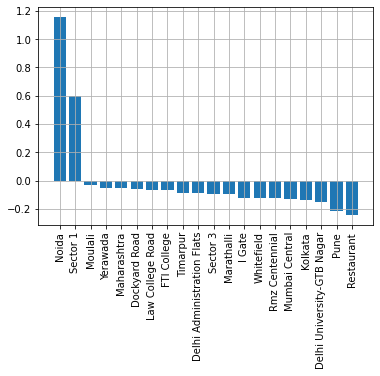

In [16]:
model_coef = pd.DataFrame(data=model_lr.coef_[0][:20], index=x.columns[:20], columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.bar(model_coef.index, model_coef['Model Coefficient'])
plt.xticks(rotation=90)
plt.grid()
plt.show()

# XGBClassifier

In [17]:
model_xgb = XGBClassifier()
train_X = X_train.values
model_xgb.fit(train_X, y_train)
scores = cross_val_score(model_xgb, train_X,y_train, cv=10) # model, train, target, cross validation
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

[11:24:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [18]:
test_X = X_test.values
pred = model_xgb.predict(test_X)
print("Test Accuracy: {}%".format(round(model_xgb.score(test_X, y_test)*100, 2)))

print(classification_report(y_test, pred))

Test Accuracy: 69.36%
              precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.72      0.94      0.81      2265
          45       0.49      0.20      0.29       766
          65       0.46      0.10      0.16       271
          80       1.00      0.20      0.33         5
         120       0.55      0.32      0.40        19

    accuracy                           0.69      3329
   macro avg       0.54      0.29      0.33      3329
weighted avg       0.65      0.69      0.64      3329



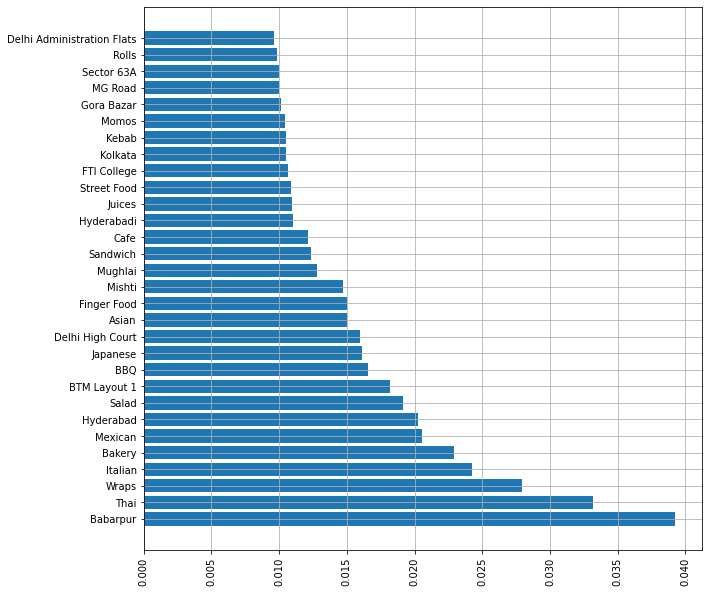

In [19]:
fig = plt.figure(figsize=(10, 10))

model_coef = pd.DataFrame(data=model_xgb.feature_importances_, index=x.columns, columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.barh(model_coef.index[:30], model_coef['Model Coefficient'][:30])
plt.xticks(rotation=90)
plt.grid()
plt.show()

# DecisionTreeClassifier

In [20]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
scores = cross_val_score(dt, X_train,y_train, cv=10) # model, train, target, cross validation
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.62934363 0.63835264 0.60875161 0.6023166  0.6023166  0.62371134
 0.63273196 0.60180412 0.63015464 0.5992268 ]
cross-val-score.mean 
0.617


In [21]:
pred = dt.predict(X_test)
print("Test Accuracy: {}%".format(round(dt.score(X_test, y_test)*100, 2)))
print(classification_report(y_test, pred))

Test Accuracy: 63.23%
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         3
          30       0.76      0.76      0.76      2265
          45       0.40      0.40      0.40       766
          65       0.27      0.27      0.27       271
          80       0.50      0.20      0.29         5
         120       0.30      0.32      0.31        19

    accuracy                           0.63      3329
   macro avg       0.32      0.28      0.29      3329
weighted avg       0.63      0.63      0.63      3329



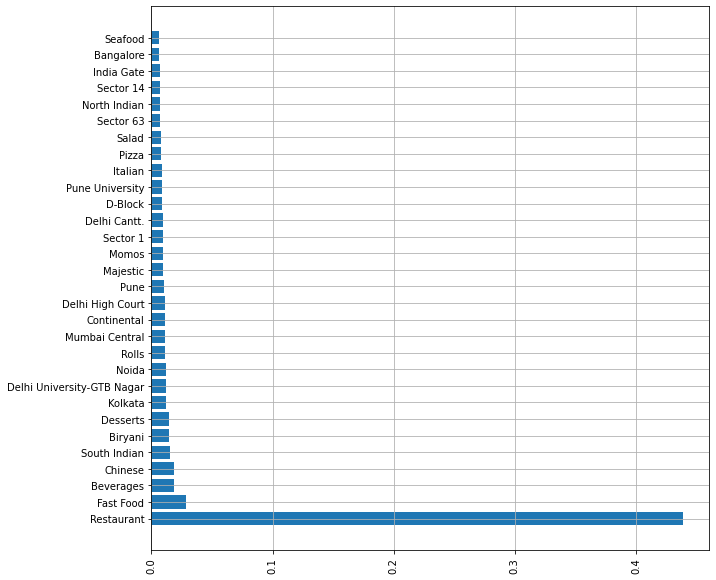

In [22]:
fig = plt.figure(figsize=(10, 10))

model_coef = pd.DataFrame(data=dt.feature_importances_, index=x.columns, columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.barh(model_coef.index[:30], model_coef['Model Coefficient'][:30])
plt.xticks(rotation=90)
plt.grid()
plt.show()

# KNN

In [23]:
best_Kvalue = 0
best_score = 0
for i in range(2,15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    score = round(knn.score(X_test, y_test)*100,2)
#     print(f"Test Accuracy: {score}%, knn number {i}")
    if score > best_score:
        
        best_score = round(score)
        best_Kvalue = i
        
print(f"Best KNN Value: {best_Kvalue}")
print(f"Test Accuracy: {best_score}%")

Best KNN Value: 8
Test Accuracy: 68%


In [24]:
knn = KNeighborsClassifier(n_neighbors=best_Kvalue)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print("KNN Classifier report: \n\n", classification_report(y_test, pred))

KNN Classifier report: 

               precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.69      0.95      0.80      2265
          45       0.40      0.10      0.16       766
          65       0.29      0.02      0.04       271
          80       0.00      0.00      0.00         5
         120       1.00      0.05      0.10        19

    accuracy                           0.68      3329
   macro avg       0.40      0.19      0.18      3329
weighted avg       0.59      0.68      0.59      3329



# SVM

In [25]:
svm = SVC(random_state=42, gamma="auto")
svm.fit(X_train, y_train)
scores = cross_val_score(svm, X_train,y_train, cv=10) 
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))


cross-val-score 
[0.66280566 0.66151866 0.66151866 0.66151866 0.66151866 0.66237113
 0.66237113 0.66237113 0.66237113 0.66237113]
cross-val-score.mean 
0.662


In [26]:
pred = svm.predict(X_test)
print("Test Accuracy: {}%".format(round(svm.score(X_test, y_test)*100, 2)))
print("SVM Classifier report: \n\n", classification_report(y_test, pred))

Test Accuracy: 68.04%
SVM Classifier report: 

               precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.68      1.00      0.81      2265
          45       0.00      0.00      0.00       766
          65       0.00      0.00      0.00       271
          80       0.00      0.00      0.00         5
         120       0.00      0.00      0.00        19

    accuracy                           0.68      3329
   macro avg       0.11      0.17      0.13      3329
weighted avg       0.46      0.68      0.55      3329



# RandomForestClassifier

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
scores = cross_val_score(rf, X_train,y_train, cv=10) 
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))


cross-val-score 
[0.61904762 0.63320463 0.61518662 0.62676963 0.62033462 0.60824742
 0.63530928 0.6121134  0.62886598 0.61984536]
cross-val-score.mean 
0.622


In [28]:
ypred = rf.predict(X_test)
print("Test Accuracy: {}%".format(round(rf.score(X_test, y_test)*100, 2)))
print("Random Forest Classifier report: \n\n", classification_report(y_test, ypred))

Test Accuracy: 61.94%
Random Forest Classifier report: 

               precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.71      0.81      0.76      2265
          45       0.33      0.25      0.28       766
          65       0.18      0.11      0.13       271
          80       1.00      0.20      0.33         5
         120       0.08      0.05      0.06        19

    accuracy                           0.62      3329
   macro avg       0.38      0.24      0.26      3329
weighted avg       0.58      0.62      0.59      3329



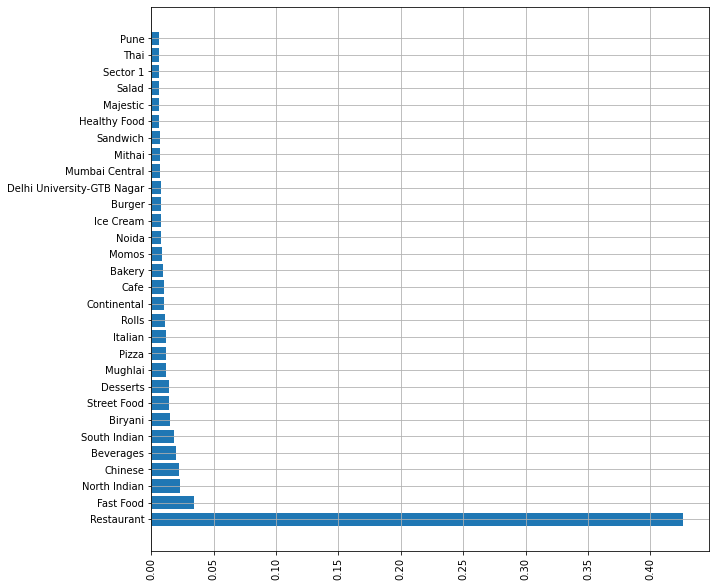

In [29]:
fig = plt.figure(figsize=(10, 10))

model_coef = pd.DataFrame(data=rf.feature_importances_, index=x.columns, columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.barh(model_coef.index[:30], model_coef['Model Coefficient'][:30])
plt.xticks(rotation=90)
plt.grid()
plt.show()

# AdaBoostClassifier

In [30]:
ada=AdaBoostClassifier()
ada.fit(X_train, y_train)
scores = cross_val_score(ada, X_train,y_train, cv=10) 
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))

cross-val-score 
[0.66409266 0.65250965 0.66151866 0.66409266 0.66409266 0.66108247
 0.66237113 0.66108247 0.66108247 0.66365979]
cross-val-score.mean 
0.662


In [31]:
ypred = ada.predict(X_test)
print("Test Accuracy: {}%".format(round(ada.score(X_test, y_test)*100, 2)))
print("Random Forest Classifier report: \n\n", classification_report(y_test, ypred))

Test Accuracy: 67.92%
Random Forest Classifier report: 

               precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.68      1.00      0.81      2265
          45       0.38      0.01      0.01       766
          65       0.00      0.00      0.00       271
          80       0.00      0.00      0.00         5
         120       0.00      0.00      0.00        19

    accuracy                           0.68      3329
   macro avg       0.18      0.17      0.14      3329
weighted avg       0.55      0.68      0.55      3329



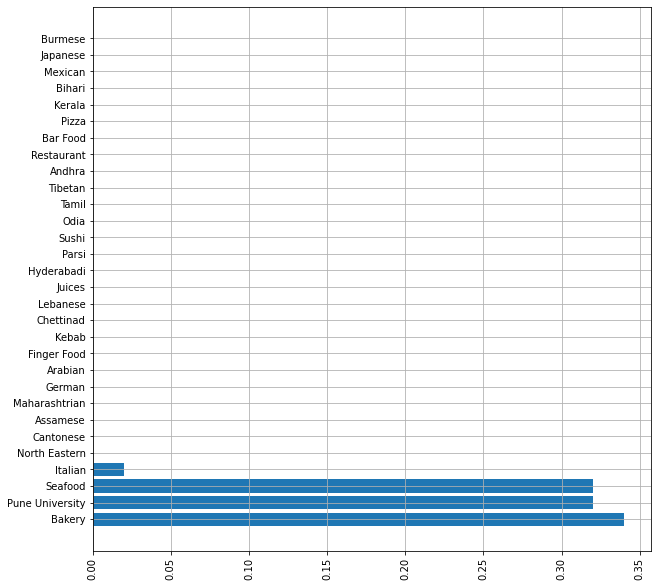

In [32]:
fig = plt.figure(figsize=(10, 10))

model_coef = pd.DataFrame(data=ada.feature_importances_, index=x.columns, columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.barh(model_coef.index[:30], model_coef['Model Coefficient'][:30])
plt.xticks(rotation=90)
plt.grid()
plt.show()

# BaggingClassifier

In [33]:
bag=BaggingClassifier()
bag.fit(X_train, y_train)
scores = cross_val_score(bag, X_train,y_train, cv=10) 
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))


cross-val-score 
[0.66924067 0.68468468 0.66280566 0.66924067 0.66151866 0.6443299
 0.66494845 0.64690722 0.67010309 0.66881443]
cross-val-score.mean 
0.664


In [34]:
ypred = bag.predict(X_test)
print("Test Accuracy: {}%".format(round(bag.score(X_test, y_test)*100, 2)))
print("Random Forest Classifier report: \n\n", classification_report(y_test, ypred))

Test Accuracy: 67.8%
Random Forest Classifier report: 

               precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.74      0.87      0.80      2265
          45       0.45      0.30      0.36       766
          65       0.38      0.17      0.24       271
          80       0.50      0.20      0.29         5
         120       0.18      0.11      0.13        19

    accuracy                           0.68      3329
   macro avg       0.37      0.28      0.30      3329
weighted avg       0.64      0.68      0.65      3329



# ExtraTreesClassifier

In [35]:
xtree=ExtraTreesClassifier()
xtree.fit(X_train, y_train)
scores = cross_val_score(xtree, X_train,y_train, cv=10) 
print('cross-val-score \n{}'.format(scores))
print('cross-val-score.mean \n{:.3f}'.format(scores.mean()))


cross-val-score 
[0.6023166  0.5984556  0.58815959 0.5958816  0.6036036  0.59149485
 0.61597938 0.59793814 0.60953608 0.58118557]
cross-val-score.mean 
0.598


In [36]:
ypred = xtree.predict(X_test)
print("Test Accuracy: {}%".format(round(xtree.score(X_test, y_test)*100, 2)))
print("Random Forest Classifier report: \n\n", classification_report(y_test, ypred))

Test Accuracy: 59.93%
Random Forest Classifier report: 

               precision    recall  f1-score   support

          20       0.00      0.00      0.00         3
          30       0.72      0.76      0.74      2265
          45       0.32      0.29      0.31       766
          65       0.19      0.15      0.17       271
          80       1.00      0.20      0.33         5
         120       0.13      0.11      0.12        19

    accuracy                           0.60      3329
   macro avg       0.39      0.25      0.28      3329
weighted avg       0.58      0.60      0.59      3329



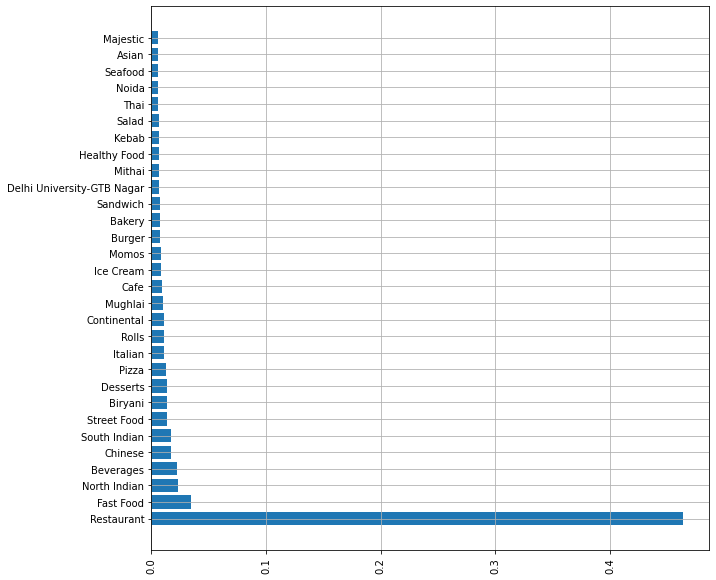

In [37]:
fig = plt.figure(figsize=(10, 10))

model_coef = pd.DataFrame(data=xtree.feature_importances_, index=x.columns, columns=['Model Coefficient'])
model_coef.sort_values(by='Model Coefficient', ascending=False, inplace=True)
plt.barh(model_coef.index[:30], model_coef['Model Coefficient'][:30])
plt.xticks(rotation=90)
plt.grid()
plt.show()

# TEST

In [38]:
test_02=test.copy()
del test_02['Cuisines']
del test_02['Location']
scaler=MinMaxScaler()
X_scaled_d = scaler.fit_transform(test_02)
X_scaled = pd.DataFrame(X_scaled_d, index=test_02.index, columns=test_02.columns)
X_scaled = X_scaled[['Restaurant']]
test_02 = pd.merge(X_scaled,test_location_df, left_index =True, right_index =True, how= 'left')
test_02 = pd.merge(test_02,test_cuisines_df, left_index =True, right_index =True, how= 'left')

test_02 = test_02.fillna(0)

x=test_02


In [39]:
test_predict = rf.predict(x)
test_pd =pd.DataFrame(rf.predict(x))
print(test_pd[0].value_counts())
print(accuracy_score(sample['Delivery_Time'],test_predict))


30     2485
45      254
65       24
20       10
120       1
Name: 0, dtype: int64
0.14383561643835616


In [40]:
#xgb test
x_values = x.values
test_predict = model_xgb.predict(x_values)
test_pd =pd.DataFrame(model_xgb.predict(x_values))
print(test_pd[0].value_counts())
print(accuracy_score(sample['Delivery_Time'],test_predict))

30     2392
45      306
65       61
120      13
20        2
Name: 0, dtype: int64
0.14311463590483056
